### An Example of Nowcasting with DLT and MMM with KTR

For more examples, check out the [Github](https://github.com/uber/orbit).

# Installation

Read the requirements file and make sure you have a C++ compiler for PyStan
Ideally use 3.7 and the stable version, install through command line.
It is recommended that the suggested code to run to enable GPU be ignored,
as it can cause issues with running multiple cores and even diagnostics.

The first part of this is running an example from the GitHub repository.
The second section is the beginning of tinkering with the reason Orbit
is an interesting possibility for MMM: the KTR model.

In [ ]:
%matplotlib inline

import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import DLT
from orbit.models import KTR
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from sklearn.preprocessing import MinMaxScaler

In [101]:
print(orbit.__version__)
print(os.name)
print(platform.system())

1.1.4dev
posix
Linux


In [102]:
seed=42

In [103]:
def mae(x, y):
    return np.mean(np.abs(x - y))

# US Weekly Initial Claims

The *iclaims* data contains the weekly initial claims for US unemployment benefits against a few related google trend queries (unemploy, filling and job) 
from Jan 2010 - June 2018. This dataset was used in the original Bayesian Structural Time-Series paper [Scott and Varan (2013)](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf) as well.

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while regressors such as google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).

In order to use this data to nowcast the US unemployment claims considering the impact of COVID-19, we extended the dataset to Jan 2021 and added the [S&P 500 (^GSPC)](https://finance.yahoo.com/quote/%5EGSPC/history?period1=1264032000&period2=1611187200&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true) and [VIX](https://finance.yahoo.com/quote/%5EVIX/history?p=%5EVIX) Index historical data for the same period.

In [104]:
# load data
df = load_iclaims(end_date='2021-01-03')
df = df[['week', 'claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']]

For SP500 index, it is more reasonable to examine the change of the index which naturally captures the shock of market's belief of the economics in future periods.

In [105]:
df[['sp500']] = df[['sp500']].diff()
df = df[1:].reset_index(drop=True)

date_col = 'week'
response_col = 'claims'
df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [106]:
df.head(5)

,week,claims,trend.unemploy,trend.job,sp500,vix
0,2010-01-10,13.624218,0.016351,0.181862,-0.007847,0.069878
1,2010-01-17,13.398741,0.032611,0.130569,-0.039749,0.491772
2,2010-01-24,13.137549,-0.000179,0.119987,-0.016522,0.388078
3,2010-01-31,13.196760,-0.069172,0.087552,-0.007177,0.446838
4,2010-02-07,13.146984,-0.182500,0.019344,0.008703,0.308205


We can see from the charts below, there are seasonlity, trend, and as well as a huge changpoint due the impact of COVID-19.

Text(0.5, 1.0, 'S&P500')

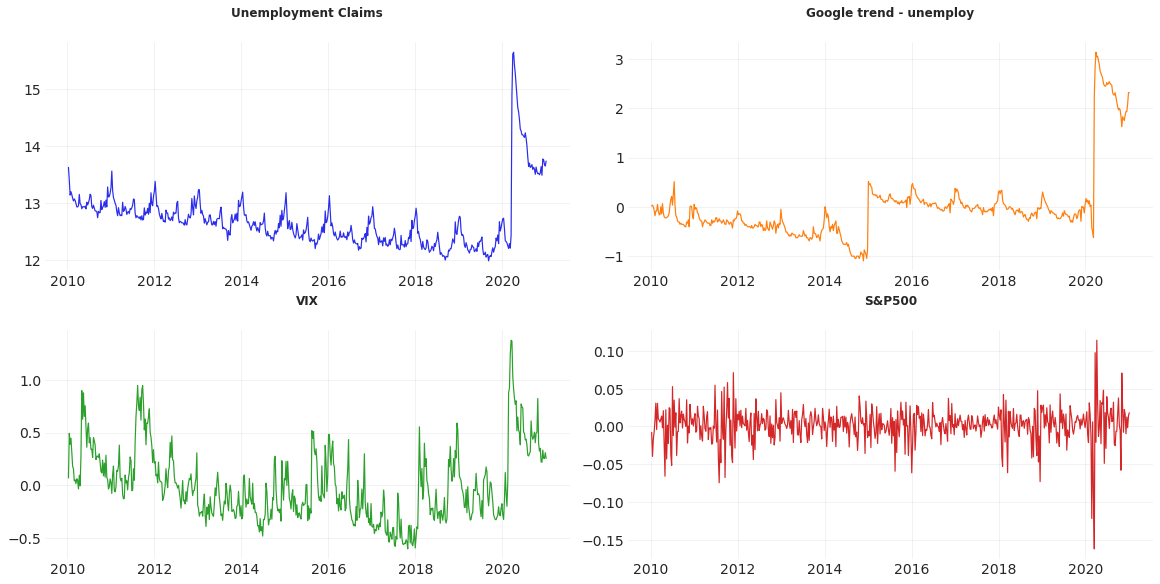

In [107]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
axs[0, 0].plot(df['week'], df['claims'])
axs[0, 0].set_title('Unemployment Claims')
axs[0, 1].plot(df['week'], df['trend.unemploy'], 'tab:orange')
axs[0, 1].set_title('Google trend - unemploy')
axs[1, 0].plot(df['week'], df['vix'], 'tab:green')
axs[1, 0].set_title('VIX')
axs[1, 1].plot(df['week'], df['sp500'], 'tab:red')
axs[1, 1].set_title('S&P500')

## Train / Test Split

To make Bayesian priors comparable across regressors, we need some transformation across regressors. For simplicity, `MixMaxScalar()` is used here. In practice, one can consider standardizing process instead.

In [108]:
test_size = 12
train_df = df[:-test_size].reset_index(drop=True)
test_df = df[-test_size:].reset_index(drop=True)

scaler = MinMaxScaler()
train_df[['claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']] = scaler.fit_transform(train_df[['claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']])
test_df[['claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']] = scaler.transform(test_df[['claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']])

# Simple DLT Model

In [109]:
dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    num_warmup=4000,
    num_sample=1000,
    estimator='stan-mcmc',
    seed=2022,
)

dlt.fit(df=train_df)
predicted_df = dlt.predict(df=test_df)

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 250.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


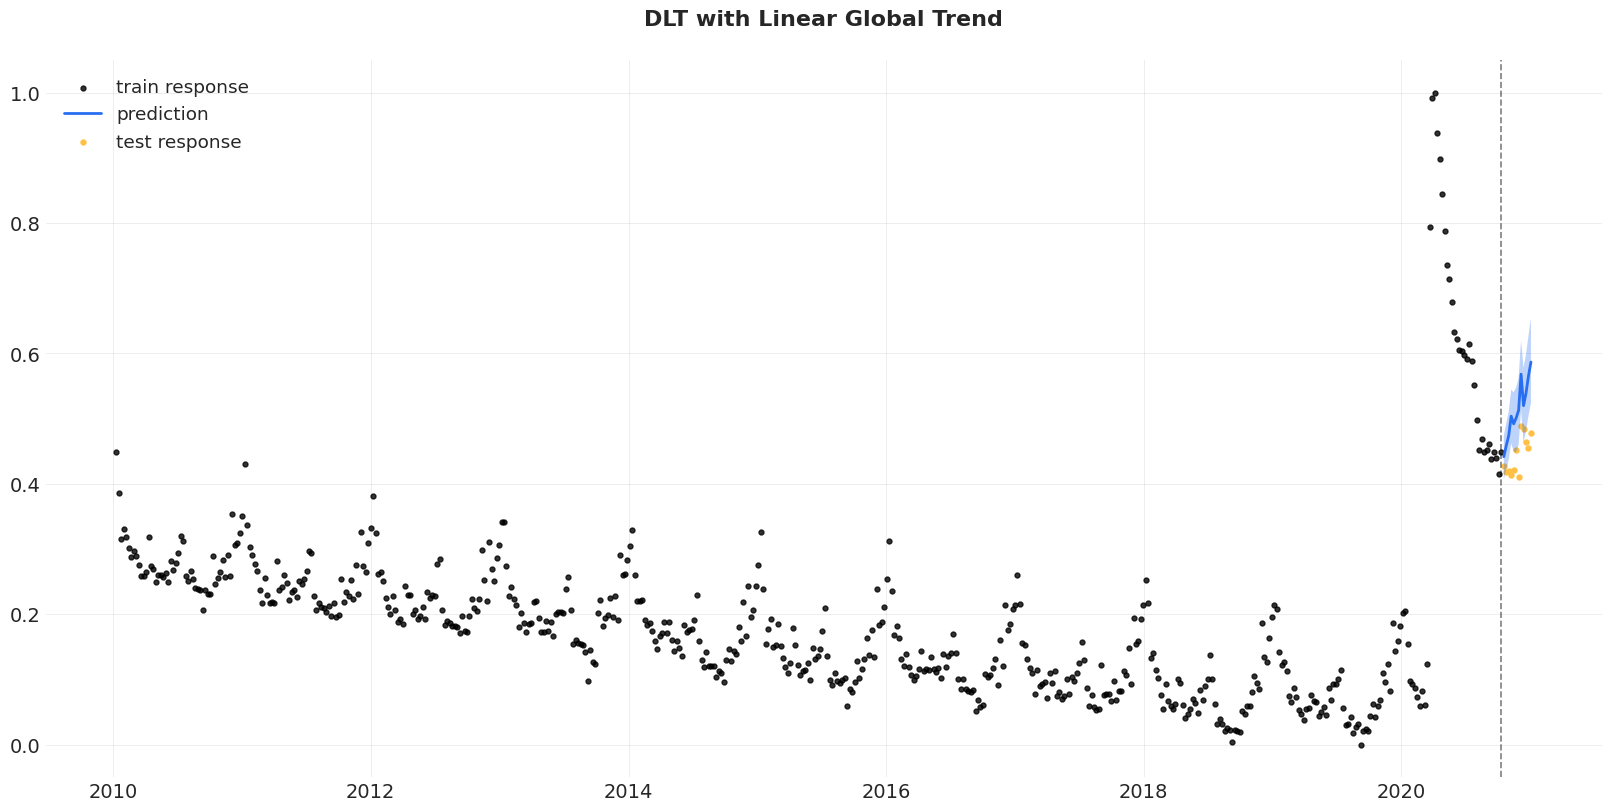

In [110]:
_ = plot_predicted_data(training_actual_df=train_df, 
                        predicted_df=predicted_df, 
                        date_col=date_col, 
                        actual_col=response_col, 
                        test_actual_df=test_df,
                        title='DLT with Linear Global Trend')

# DLT With Regression

In this session, a regression component is added on top of the `DLT` model.

The regressor columns can be supplied via argument `regressor_col`.  Recall the regression formula in **DLT**:

$$
\hat{y}_t =\mu_t + s_t + r_t \\
r_t = \sum_{j}\beta_j x_{jt} \\
\beta_j ~\sim \mathcal{N}(\mu_j, \sigma_j^2)
$$

Let's use the default (non-informative priors) where $\mu_j = 0$ and $\sigma_j = 1$.

## Regular Regression

In [111]:
dlt_reg = DLT(
    response_col=response_col, 
    date_col=date_col,
    regressor_col=['trend.unemploy', 'trend.job', 'sp500', 'vix'],
    seasonality=52,
    num_warmup=4000,
    num_sample=1000,
    estimator='stan-mcmc',
    seed=2022,
)

dlt_reg.fit(df=train_df)
predicted_df_reg = dlt_reg.predict(test_df, decompose=True)

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 250.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


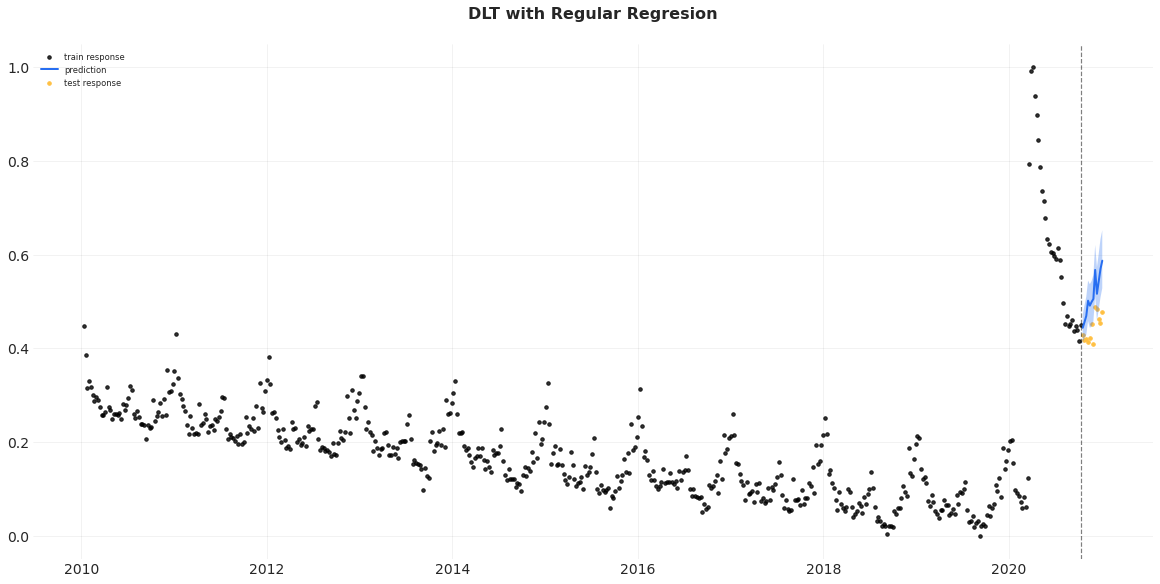

In [112]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg, 
                        date_col=date_col, actual_col=response_col, test_actual_df=test_df,
                        use_orbit_style=False,
                        title='DLT with Regular Regresion')

The estimated regressor coefficients can be retrieved via `.get_regression_coefs()`.

In [113]:
dlt_reg.get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,trend.unemploy,Regular,0.093732,0.055674,0.127304,1.000,0.000
1,trend.job,Regular,-0.020737,-0.045591,0.003561,0.087,0.913
2,sp500,Regular,0.000828,-0.013451,0.015226,0.544,0.456
3,vix,Regular,0.005710,-0.009565,0.022219,0.743,0.257


# Diagnoses

## Decomposition 

`plot_predicted_components` is the utility to plot each component separately. This is useful when one wants to look into the model prediction results and inspect each component separately.

/home/matt/anaconda3/envs/orbit/lib/python3.7/site-packages/orbit/diagnostics/plot.py:313: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


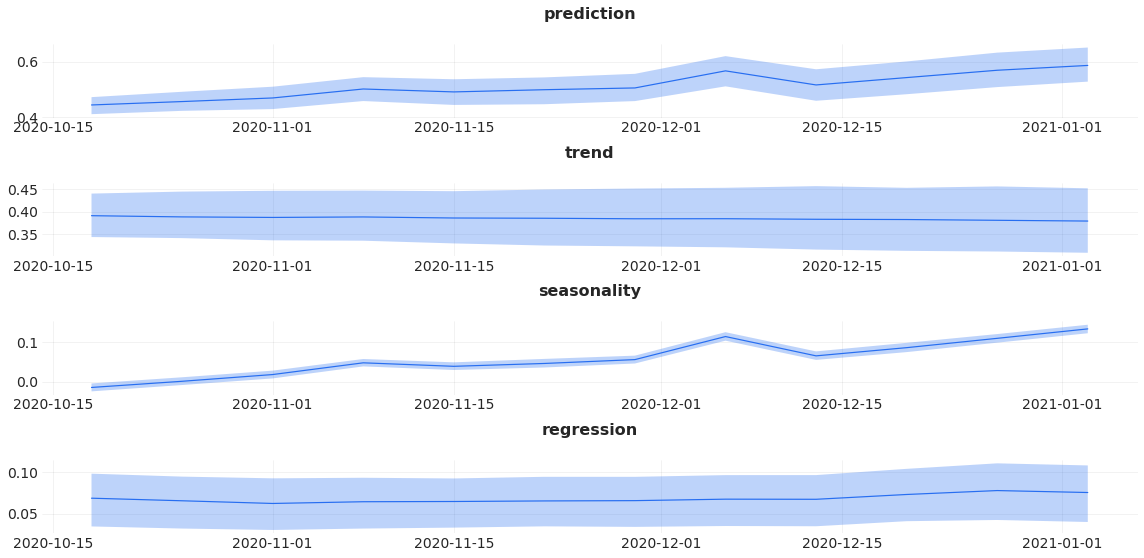

In [114]:
_ = plot_predicted_components(predicted_df_reg, date_col, 
                              use_orbit_style=False,
                              plot_components=['prediction', 'trend', 'seasonality', 'regression'])

## Posterior Diagnostic Visualizations

A few diagnostic plots is recommended for Orbit models. With `version>=1.1.0`,

These plots can be created directly in [Arivz](https://github.com/arviz-devs/arviz) which is a Python package for exploratory analysis of Bayesian models, includes functions for posterior analysis, data storage, model checking, comparison and diagnostics. Two plots can be found below:

1. Trace plot
2. Pair density plot

-

In [115]:
import arviz as az
az.style.use('arviz-darkgrid')

### Trace plot

Trace plot shows the iterations of each paramter over the Markov chian sampling process. Trace plots provide an important tool for assessing mixing of a chain.

In [116]:
ps = dlt_reg.get_posterior_samples(relabel=True, permute=False)
ps.keys()

odict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'gt_sum', 'gb', 'gl', 'trend.unemploy', 'trend.job', 'sp500', 'vix'])

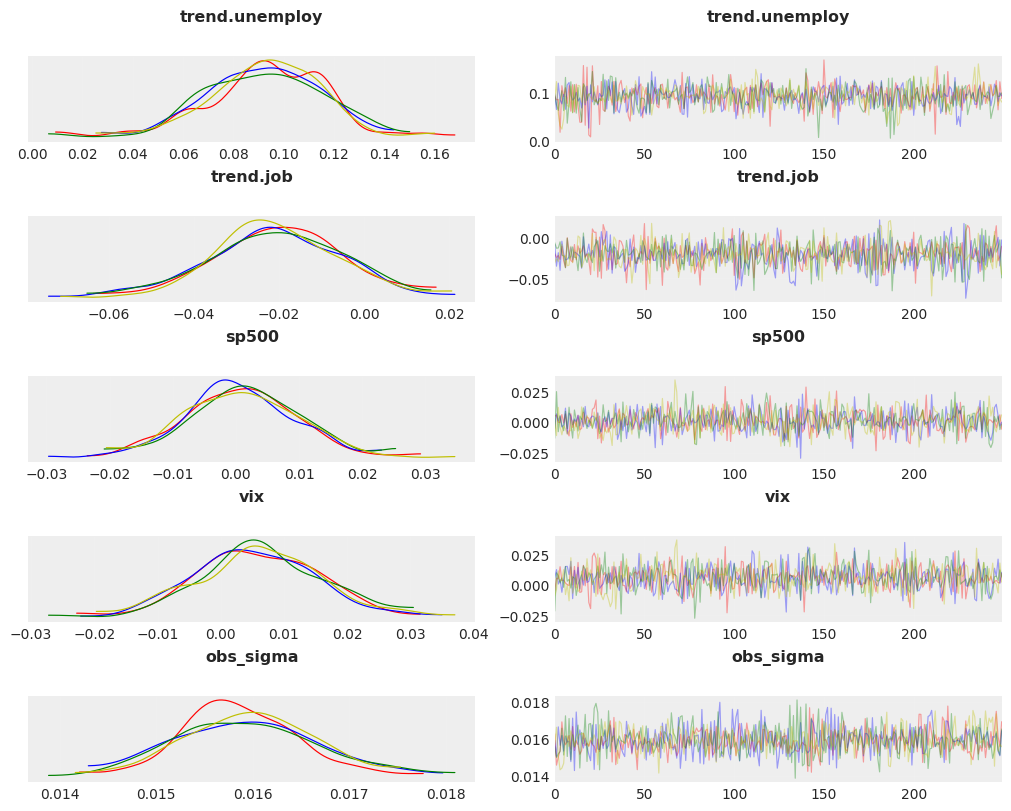

In [117]:
az.plot_trace(
    ps,
    var_names=['trend.unemploy', 'trend.job', 'sp500', 'vix', 'obs_sigma'],
    chain_prop={"color": ['r', 'b', 'g', 'y']},
    figsize=(10, 8),
);

### Pair density plot

We can also check the density of samples by pair plot.

In [118]:
# az.plot_pair(
#     ps,
#     var_names=['trend.unemploy', 'trend.job', 'sp500', 'vix', 'obs_sigma'],
#     kind=["scatter", "kde"],
#     marginals=True,
#     point_estimate="median",
#     textsize=10.5,
#     figsize=(8,8)
# );

# Regression with Informative Priors / Regularized Priors

Due to various reasons, users may obtain further knowledge on some of the regressors or they want to propose different regularization on different regressors. These informative priors basically means to replace the defaults ($\mu$, $\sigma$) mentioned previously. In orbit, this process is done via the arguments `regressor_beta_prior` and `regressor_sigma_prior`. These two lists should be of the same length as `regressor_col`.

In addition, we can set a *sign* constraint for each coefficient $\beta_j$.  This is can be done by supplying the `regressor_sign` as a list where elements are in one of followings:

* '=': $\beta_j ~\sim \mathcal{N}(0, \sigma_j^2)$  i.e. $\beta_j \in (-\inf, \inf)$
* '+': $\beta_j ~\sim \mathcal{N}^+(0, \sigma_j^2)$  i.e. $\beta_j \in [0, \inf)$
* '-': $\beta_j ~\sim \mathcal{N}^-(0, \sigma_j^2)$  i.e. $\beta_j \in (-\inf, 0]$

Based on intuition, it's reasonable to assume search terms such as "unemployment", "filling" and **VIX** index to be positively correlated (`+` sign is used in this case) and upward shock of **SP500** (`-` sign) to be negatively correlated to the outcome. Otherwise, an unbounded coefficient can be used (`=` sign).

Furthermore, regressors such as seach queries may have more direct impact than stock marker indices.  Hence, a smaller $\sigma$ is considered.

In [119]:
dlt_reg_adjust = DLT(
    response_col=response_col,
    date_col=date_col,
    regressor_col=['trend.unemploy', 'trend.job', 'sp500','vix'],
    regressor_sign=['+','=','-','+'],
    regressor_sigma_prior=[0.3, 0.1, 0.05, 0.1],
    num_warmup=4000,
    num_sample=1000,
    estimator='stan-mcmc',
    seed=2022,
)
dlt_reg_adjust.fit(df=train_df)
predicted_df_reg_adjust = dlt_reg_adjust.predict(test_df, decompose=True)

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 250.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


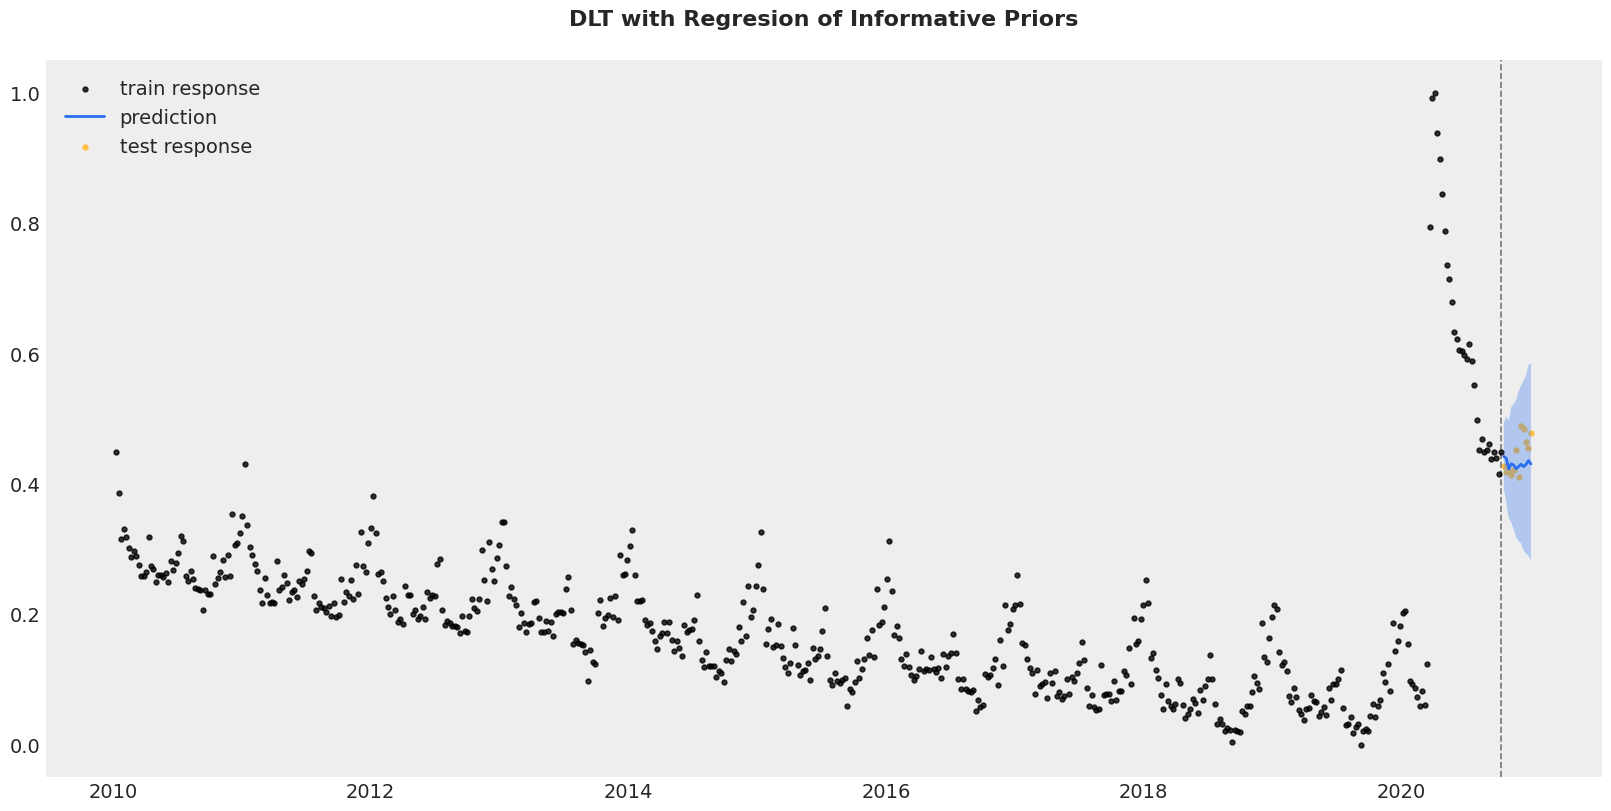

In [120]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg_adjust, 
                        date_col=date_col, actual_col=response_col, test_actual_df=test_df,
                        use_orbit_style=False,
                        title='DLT with Regresion of Informative Priors')

In [121]:
dlt_reg_adjust.get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,trend.unemploy,Positive,0.144865,0.085550,0.235510,1.000,0.000
1,vix,Positive,0.007795,0.000758,0.025581,1.000,0.000
2,sp500,Negative,-0.006719,-0.022028,-0.000467,0.001,0.999
3,trend.job,Regular,-0.004602,-0.042976,0.030726,0.417,0.583


In [122]:
naive_mae = mae(predicted_df['prediction'].values, test_df['claims'].values)
reg_mae = mae(predicted_df_reg['prediction'].values, test_df['claims'].values)
reg_adjust_mae = mae(predicted_df_reg_adjust['prediction'].values, test_df['claims'].values)

print("----------------Mean Absolute Error Summary----------------")
print("Naive Model: {:.3f}\nRegression Model: {:.3f}\nRefined Regression Model: {:.3f}".format(
    naive_mae, reg_mae, reg_adjust_mae
))

----------------Mean Absolute Error Summary----------------
Naive Model: 0.069
Regression Model: 0.068
Refined Regression Model: 0.027


## Summary

This demo showcases a use case in nowcasting. Although this may not be applicable in real-time forecasting, it mainly introduces the regression analysis with time-series modeling in `Orbit`. For people who have concerns on the forecastability, one can consider introducing lag on regressors.

Also, `Orbit` allows informative priors where sometime can be useful in combining multiple source of insights together.

In [123]:
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand
from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())

In [140]:
data = pd.read_csv("/home/matt/DataspellProjects/mercury-ds/attribution/MMM/Robyn/robyn_sim_weekly.csv")
date_col = "DATE"
response_col = "revenue"
regressor_col = ['search_S', 'facebook_S']
print(data.shape)
data.head()

(208, 12)


,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2754371.67,167687.6,0.0,95463.67,72903852.71,0.00,0.0,8125009.0,228213.99,na,19401.65
1,2015-11-30,2584276.67,214600.9,0.0,0.00,16581099.55,29511.72,31000.0,7901549.0,34258.57,na,14791.00
2,2015-12-07,2547386.67,0.0,248022.0,3404.00,49954773.67,36132.36,28400.0,8300197.0,127691.26,na,14544.00
3,2015-12-14,2875220.00,625877.3,0.0,132600.00,31649297.03,36804.21,31900.0,8122883.0,84014.72,na,2800.00
4,2015-12-21,2215953.33,0.0,520005.0,0.00,8802269.48,28401.74,27100.0,7105985.0,20687.48,na,15478.00


In [125]:
test_size = 26
train_data = data[:-test_size]
test_data = data[-test_size:]

In [141]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    regressor_col=regressor_col,
    seed=42,
    # seasonality=[52],
    # seasonality_fs_order=[2, 5],
    # level_knot_scale=.1,
    # level_segments=10,
    # regression_segments=0,
    prediction_percentiles=[2.5, 97.5],
    # pyro optimization parameters
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi'
    # n_bootstrap_draws=1e4,
    # ktrlite_optim_args = dict()
)

ktr.fit(df=data)

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Using SVI (Pyro) with steps: 1000, samples: 1000, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:root:Guessed max_plate_nesting = 1
INFO:orbit:step    0 loss = 1.3237e+05, scale = 0.091257
INFO:orbit:step  100 loss = 4589.7, scale = 0.14675
INFO:orbit:step  200 loss = 6406.4, scale = 0.13995
INFO:orbit:step  300 loss = 5194.2, scale = 0.15082
INFO:orbit:step  400 loss = 5898.5, scale = 0.1526
INFO:orbit:step  500 loss = 4392.8, scale = 0.13758
INFO:orbit:step  600 loss = 4424.4, scale = 0.15301
INFO:orbit:step  700 loss = 4135, scale = 0.15315
INFO:orbit:step  800 loss = 3806.1, scale = 0.15554
INFO:orbit:step  900 loss = 4939.3, scale = 0.15206


In [142]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)
print(coef_mid)

          DATE  search_S  facebook_S
0   2015-11-23 -0.834072    0.397987
1   2015-11-30 -0.833999    0.398067
2   2015-12-07 -0.833924    0.398147
3   2015-12-14 -0.833846    0.398226
4   2015-12-21 -0.833766    0.398305
..         ...       ...         ...
203 2019-10-14 -0.845603    0.392070
204 2019-10-21 -0.845781    0.392042
205 2019-10-28 -0.845955    0.392016
206 2019-11-04 -0.846125    0.391991
207 2019-11-11 -0.846292    0.391967

[208 rows x 3 columns]


In [128]:
predicted = ktr.predict(df=test_data, decompose=True).head(5)

TypeError: '<' not supported between instances of 'numpy.ndarray' and 'str'

In [ ]:
_ = ktr.plot_lev_knots()